<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S8_AssignmentSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load required libraries**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
import torchvision
import numpy as np
import sys


In [6]:
# mount the drive 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# add path to our library in default search path
sys.path.append('/content/drive/My Drive/EVA4B2-TSAI/EVA4_Library')

**Import packages from Drive**

In [0]:
import execute # this is to train & test the model
import image_transformations # to apply different image transformations
import DataLoaders as loader
import visualizeData as viz
import cifar10_models as models # consists of CNN models built on CIFAR10 Dataset

In [0]:
# Apply Image Transforms

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)

fillMeans = (np.array(channel_means)*255).astype(np.uint8)
trans = image_transformations.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)

trainTrans = trans.train_transforms([
                                     transforms.RandomRotation((-15.0, 10.0), fill=tuple(fillMeans)),
                                     transforms.RandomHorizontalFlip(p=0.5)
])
testTrans = trans.test_transforms()
                                       

In [29]:
# Load Train & Test Dataset

train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = trainTrans)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = testTrans)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [0]:
# DataLoader for Train & Test

dl = loader.DataLoaders()
trainloader = dl.dataLoader(train)
testloader = dl.dataLoader(test) 


**Show some Images**

plane   dog  deer  deer


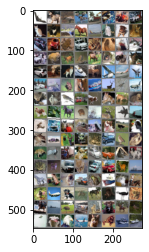

In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
viz.plotImage(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])




In [32]:
# Model Summary

!pip install torchsummary
from torchsummary import summary


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Device set to', device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))


Device set to cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, trainloader, optimizer, epoch,scheduler, criterion, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, testloader,filename, criterion, incorrect_samples):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(device), target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  
            test_loss = criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()  
            
            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))

            # This is extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})

      test_loss /= len(testloader.dataset)
      self.test_losses.append(test_loss)      

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
    
      self.test_acc.append(100. * correct / len(testloader.dataset))



In [0]:

def cross_entropy_loss():
    """Create Cross Entropy Loss
    Returns:
        Cross entroy loss function
    """
    return nn.CrossEntropyLoss()



In [35]:
incorrect_samples = []
model = ResNet18().to(device)


criterion = cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader), epochs=15)

model1 =Test_Train()
EPOCHS = 15

for epoch in range(1,EPOCHS+1):
  print("EPOCH:", epoch)
  model1.train(model, device, trainloader, optimizer, epoch, scheduler,criterion, L1lambda=1e-5)
  model1.test(model, device, testloader,"model.pt", criterion, incorrect_samples)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1



Loss=3.475573778152466 Batch_id=0 Accuracy=8.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=3.475573778152466 Batch_id=0 Accuracy=8.59:   0%|          | 1/391 [00:00<02:12,  2.95it/s]
Loss=3.388761520385742 Batch_id=1 Accuracy=9.77:   0%|          | 1/391 [00:00<02:12,  2.95it/s]
Loss=3.388761520385742 Batch_id=1 Accuracy=9.77:   1%|          | 2/391 [00:00<01:46,  3.66it/s]
Loss=3.3560914993286133 Batch_id=2 Accuracy=12.50:   1%|          | 2/391 [00:00<01:46,  3.66it/s]
Loss=3.3560914993286133 Batch_id=2 Accuracy=12.50:   1%|          | 3/391 [00:00<01:26,  4.50it/s]
Loss=3.375187397003174 Batch_id=3 Accuracy=13.28:   1%|          | 3/391 [00:00<01:26,  4.50it/s] 
Loss=3.375908374786377 Batch_id=4 Accuracy=13.91:   1%|          | 3/391 [00:00<01:26,  4.50it/s]
Loss=3.375908374786377 Batch_id=4 Accuracy=13.91:   1%|▏         | 5/391 [00:00<01:09,  5.58it/s]
Loss=3.3603310585021973 Batch_id=5 Accuracy=14.97:   1%|▏         | 5/391 [00:00<01:09,  5.58it/s]
Loss=3.3924756050109863 Bat

Validation loss has  decreased (inf --> 0.0002).  Saving model ...

Test set: Average loss: 0.0002, Accuracy: 5530/10000 (55.30%)

EPOCH: 2



Loss=2.063368797302246 Batch_id=0 Accuracy=58.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.063368797302246 Batch_id=0 Accuracy=58.59:   0%|          | 1/391 [00:00<02:49,  2.30it/s]
Loss=2.027269124984741 Batch_id=1 Accuracy=62.89:   0%|          | 1/391 [00:00<02:49,  2.30it/s]
Loss=2.4585516452789307 Batch_id=2 Accuracy=59.90:   0%|          | 1/391 [00:00<02:49,  2.30it/s]
Loss=2.4585516452789307 Batch_id=2 Accuracy=59.90:   1%|          | 3/391 [00:00<02:07,  3.04it/s]
Loss=2.37583065032959 Batch_id=3 Accuracy=58.79:   1%|          | 3/391 [00:00<02:07,  3.04it/s]  
Loss=2.219578981399536 Batch_id=4 Accuracy=59.53:   1%|          | 3/391 [00:00<02:07,  3.04it/s]
Loss=2.219578981399536 Batch_id=4 Accuracy=59.53:   1%|▏         | 5/391 [00:00<01:38,  3.91it/s]
Loss=2.2940094470977783 Batch_id=5 Accuracy=58.59:   1%|▏         | 5/391 [00:00<01:38,  3.91it/s]
Loss=2.2911484241485596 Batch_id=6 Accuracy=58.59:   1%|▏         | 5/391 [00:00<01:38,  3.91it/s]
Loss=2.291148424148559

Validation loss has  decreased (0.0002 --> 0.0001).  Saving model ...

Test set: Average loss: 0.0001, Accuracy: 6647/10000 (66.47%)

EPOCH: 3



Loss=1.7194819450378418 Batch_id=0 Accuracy=70.31:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.7194819450378418 Batch_id=0 Accuracy=70.31:   0%|          | 1/391 [00:00<02:48,  2.32it/s]
Loss=1.9227063655853271 Batch_id=1 Accuracy=67.97:   0%|          | 1/391 [00:00<02:48,  2.32it/s]
Loss=1.8381232023239136 Batch_id=2 Accuracy=68.23:   0%|          | 1/391 [00:00<02:48,  2.32it/s]
Loss=1.8381232023239136 Batch_id=2 Accuracy=68.23:   1%|          | 3/391 [00:00<02:07,  3.05it/s]
Loss=1.768661379814148 Batch_id=3 Accuracy=68.16:   1%|          | 3/391 [00:00<02:07,  3.05it/s] 
Loss=1.7761452198028564 Batch_id=4 Accuracy=68.28:   1%|          | 3/391 [00:00<02:07,  3.05it/s]
Loss=1.7761452198028564 Batch_id=4 Accuracy=68.28:   1%|▏         | 5/391 [00:00<01:37,  3.96it/s]
Loss=1.6773947477340698 Batch_id=5 Accuracy=69.27:   1%|▏         | 5/391 [00:00<01:37,  3.96it/s]
Loss=1.9360811710357666 Batch_id=6 Accuracy=69.42:   1%|▏         | 5/391 [00:00<01:37,  3.96it/s]
Loss=1.9360811710


Test set: Average loss: 0.0001, Accuracy: 7179/10000 (71.79%)

EPOCH: 4



Loss=1.7680997848510742 Batch_id=0 Accuracy=67.97:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.7680997848510742 Batch_id=0 Accuracy=67.97:   0%|          | 1/391 [00:00<02:40,  2.44it/s]
Loss=1.5172507762908936 Batch_id=1 Accuracy=71.88:   0%|          | 1/391 [00:00<02:40,  2.44it/s]
Loss=1.605011224746704 Batch_id=2 Accuracy=72.66:   0%|          | 1/391 [00:00<02:40,  2.44it/s] 
Loss=1.605011224746704 Batch_id=2 Accuracy=72.66:   1%|          | 3/391 [00:00<02:01,  3.19it/s]
Loss=1.3959431648254395 Batch_id=3 Accuracy=74.22:   1%|          | 3/391 [00:00<02:01,  3.19it/s]
Loss=1.4783656597137451 Batch_id=4 Accuracy=74.69:   1%|          | 3/391 [00:00<02:01,  3.19it/s]
Loss=1.4783656597137451 Batch_id=4 Accuracy=74.69:   1%|▏         | 5/391 [00:00<01:33,  4.12it/s]
Loss=1.5147769451141357 Batch_id=5 Accuracy=74.87:   1%|▏         | 5/391 [00:00<01:33,  4.12it/s]
Loss=1.534423589706421 Batch_id=6 Accuracy=74.78:   1%|▏         | 5/391 [00:00<01:33,  4.12it/s] 
Loss=1.53442358970

Validation loss has  decreased (0.0001 --> 0.0001).  Saving model ...

Test set: Average loss: 0.0001, Accuracy: 7326/10000 (73.26%)

EPOCH: 5



Loss=1.289405107498169 Batch_id=0 Accuracy=80.47:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.289405107498169 Batch_id=0 Accuracy=80.47:   0%|          | 1/391 [00:00<02:51,  2.27it/s]
Loss=1.448527216911316 Batch_id=1 Accuracy=77.73:   0%|          | 1/391 [00:00<02:51,  2.27it/s]
Loss=1.3365697860717773 Batch_id=2 Accuracy=79.17:   0%|          | 1/391 [00:00<02:51,  2.27it/s]
Loss=1.3365697860717773 Batch_id=2 Accuracy=79.17:   1%|          | 3/391 [00:00<02:09,  3.00it/s]
Loss=1.36827552318573 Batch_id=3 Accuracy=79.69:   1%|          | 3/391 [00:00<02:09,  3.00it/s]  
Loss=1.614348292350769 Batch_id=4 Accuracy=78.12:   1%|          | 3/391 [00:00<02:09,  3.00it/s]
Loss=1.614348292350769 Batch_id=4 Accuracy=78.12:   1%|▏         | 5/391 [00:00<01:39,  3.89it/s]
Loss=1.0616085529327393 Batch_id=5 Accuracy=79.95:   1%|▏         | 5/391 [00:00<01:39,  3.89it/s]
Loss=1.3046417236328125 Batch_id=6 Accuracy=80.36:   1%|▏         | 5/391 [00:00<01:39,  3.89it/s]
Loss=1.304641723632812


Test set: Average loss: 0.0001, Accuracy: 7764/10000 (77.64%)

EPOCH: 6



Loss=1.0780963897705078 Batch_id=0 Accuracy=85.16:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.0780963897705078 Batch_id=0 Accuracy=85.16:   0%|          | 1/391 [00:00<02:54,  2.24it/s]
Loss=1.1127750873565674 Batch_id=1 Accuracy=83.20:   0%|          | 1/391 [00:00<02:54,  2.24it/s]
Loss=1.2458267211914062 Batch_id=2 Accuracy=81.51:   0%|          | 1/391 [00:00<02:54,  2.24it/s]
Loss=1.2458267211914062 Batch_id=2 Accuracy=81.51:   1%|          | 3/391 [00:00<02:10,  2.97it/s]
Loss=1.2604604959487915 Batch_id=3 Accuracy=80.66:   1%|          | 3/391 [00:00<02:10,  2.97it/s]
Loss=1.2047669887542725 Batch_id=4 Accuracy=80.47:   1%|          | 3/391 [00:00<02:10,  2.97it/s]
Loss=1.2047669887542725 Batch_id=4 Accuracy=80.47:   1%|▏         | 5/391 [00:00<01:40,  3.83it/s]
Loss=1.0488953590393066 Batch_id=5 Accuracy=81.25:   1%|▏         | 5/391 [00:00<01:40,  3.83it/s]
Loss=1.3346991539001465 Batch_id=6 Accuracy=80.13:   1%|▏         | 5/391 [00:00<01:40,  3.83it/s]
Loss=1.3346991539


Test set: Average loss: 0.0001, Accuracy: 7977/10000 (79.77%)

EPOCH: 7



Loss=1.193216323852539 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.193216323852539 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<02:36,  2.49it/s]
Loss=1.088057279586792 Batch_id=1 Accuracy=82.03:   0%|          | 1/391 [00:00<02:36,  2.49it/s]
Loss=1.088057279586792 Batch_id=1 Accuracy=82.03:   1%|          | 2/391 [00:00<02:00,  3.22it/s]
Loss=1.1470428705215454 Batch_id=2 Accuracy=82.81:   1%|          | 2/391 [00:00<02:00,  3.22it/s]
Loss=1.0373305082321167 Batch_id=3 Accuracy=83.98:   1%|          | 2/391 [00:00<02:00,  3.22it/s]
Loss=1.0373305082321167 Batch_id=3 Accuracy=83.98:   1%|          | 4/391 [00:00<01:33,  4.13it/s]
Loss=1.156367301940918 Batch_id=4 Accuracy=83.59:   1%|          | 4/391 [00:00<01:33,  4.13it/s] 
Loss=1.0574771165847778 Batch_id=5 Accuracy=83.59:   1%|          | 4/391 [00:00<01:33,  4.13it/s]
Loss=1.0574771165847778 Batch_id=5 Accuracy=83.59:   2%|▏         | 6/391 [00:00<01:14,  5.18it/s]
Loss=1.01805138587951


Test set: Average loss: 0.0001, Accuracy: 8081/10000 (80.81%)

EPOCH: 8



Loss=1.0213005542755127 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.0213005542755127 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<02:43,  2.38it/s]
Loss=1.0812780857086182 Batch_id=1 Accuracy=81.64:   0%|          | 1/391 [00:00<02:43,  2.38it/s]
Loss=1.0143001079559326 Batch_id=2 Accuracy=82.29:   0%|          | 1/391 [00:00<02:43,  2.38it/s]
Loss=1.0143001079559326 Batch_id=2 Accuracy=82.29:   1%|          | 3/391 [00:00<02:04,  3.13it/s]
Loss=0.9766560792922974 Batch_id=3 Accuracy=83.01:   1%|          | 3/391 [00:00<02:04,  3.13it/s]
Loss=1.0225486755371094 Batch_id=4 Accuracy=82.66:   1%|          | 3/391 [00:00<02:04,  3.13it/s]
Loss=1.0225486755371094 Batch_id=4 Accuracy=82.66:   1%|▏         | 5/391 [00:00<01:35,  4.04it/s]
Loss=0.8659535646438599 Batch_id=5 Accuracy=84.11:   1%|▏         | 5/391 [00:00<01:35,  4.04it/s]
Loss=1.0447026491165161 Batch_id=6 Accuracy=84.26:   1%|▏         | 5/391 [00:00<01:35,  4.04it/s]
Loss=1.0447026491

Validation loss has  decreased (0.0001 --> 0.0000).  Saving model ...

Test set: Average loss: 0.0000, Accuracy: 7957/10000 (79.57%)

EPOCH: 9



Loss=0.9939101934432983 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.9939101934432983 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<02:43,  2.38it/s]
Loss=0.9340944290161133 Batch_id=1 Accuracy=84.77:   0%|          | 1/391 [00:00<02:43,  2.38it/s]
Loss=1.015559434890747 Batch_id=2 Accuracy=83.59:   0%|          | 1/391 [00:00<02:43,  2.38it/s] 
Loss=1.015559434890747 Batch_id=2 Accuracy=83.59:   1%|          | 3/391 [00:00<02:03,  3.13it/s]
Loss=0.8932063579559326 Batch_id=3 Accuracy=84.57:   1%|          | 3/391 [00:00<02:03,  3.13it/s]
Loss=0.9417777061462402 Batch_id=4 Accuracy=84.69:   1%|          | 3/391 [00:00<02:03,  3.13it/s]
Loss=0.9417777061462402 Batch_id=4 Accuracy=84.69:   1%|▏         | 5/391 [00:00<01:35,  4.03it/s]
Loss=1.0041711330413818 Batch_id=5 Accuracy=84.51:   1%|▏         | 5/391 [00:00<01:35,  4.03it/s]
Loss=1.0693244934082031 Batch_id=6 Accuracy=84.15:   1%|▏         | 5/391 [00:00<01:35,  4.03it/s]
Loss=1.06932449340

Validation loss has  decreased (0.0000 --> 0.0000).  Saving model ...

Test set: Average loss: 0.0000, Accuracy: 8441/10000 (84.41%)

EPOCH: 10



Loss=1.0276895761489868 Batch_id=0 Accuracy=82.81:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.0276895761489868 Batch_id=0 Accuracy=82.81:   0%|          | 1/391 [00:00<02:11,  2.96it/s]
Loss=0.7762739658355713 Batch_id=1 Accuracy=87.50:   0%|          | 1/391 [00:00<02:11,  2.96it/s]
Loss=0.7762739658355713 Batch_id=1 Accuracy=87.50:   1%|          | 2/391 [00:00<01:46,  3.65it/s]
Loss=0.8645826578140259 Batch_id=2 Accuracy=87.76:   1%|          | 2/391 [00:00<01:46,  3.65it/s]
Loss=0.9229981899261475 Batch_id=3 Accuracy=85.94:   1%|          | 2/391 [00:00<01:46,  3.65it/s]
Loss=0.9229981899261475 Batch_id=3 Accuracy=85.94:   1%|          | 4/391 [00:00<01:24,  4.59it/s]
Loss=1.020275354385376 Batch_id=4 Accuracy=85.00:   1%|          | 4/391 [00:00<01:24,  4.59it/s] 
Loss=0.9084011316299438 Batch_id=5 Accuracy=85.42:   1%|          | 4/391 [00:00<01:24,  4.59it/s]
Loss=0.9084011316299438 Batch_id=5 Accuracy=85.42:   2%|▏         | 6/391 [00:00<01:08,  5.64it/s]
Loss=0.9254926443


Test set: Average loss: 0.0001, Accuracy: 8472/10000 (84.72%)

EPOCH: 11



Loss=0.7957784533500671 Batch_id=0 Accuracy=89.84:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.7957784533500671 Batch_id=0 Accuracy=89.84:   0%|          | 1/391 [00:00<02:32,  2.56it/s]
Loss=1.0271599292755127 Batch_id=1 Accuracy=85.16:   0%|          | 1/391 [00:00<02:32,  2.56it/s]
Loss=0.8359948992729187 Batch_id=2 Accuracy=85.94:   0%|          | 1/391 [00:00<02:32,  2.56it/s]
Loss=0.8359948992729187 Batch_id=2 Accuracy=85.94:   1%|          | 3/391 [00:00<01:57,  3.30it/s]
Loss=0.7943416833877563 Batch_id=3 Accuracy=87.11:   1%|          | 3/391 [00:00<01:57,  3.30it/s]
Loss=0.9906904697418213 Batch_id=4 Accuracy=86.56:   1%|          | 3/391 [00:00<01:57,  3.30it/s]
Loss=0.9906904697418213 Batch_id=4 Accuracy=86.56:   1%|▏         | 5/391 [00:00<01:31,  4.21it/s]
Loss=0.8406352996826172 Batch_id=5 Accuracy=86.46:   1%|▏         | 5/391 [00:00<01:31,  4.21it/s]
Loss=0.9542016983032227 Batch_id=6 Accuracy=86.05:   1%|▏         | 5/391 [00:00<01:31,  4.21it/s]
Loss=0.9542016983

Validation loss has  decreased (0.0000 --> 0.0000).  Saving model ...

Test set: Average loss: 0.0000, Accuracy: 8650/10000 (86.50%)

EPOCH: 12



Loss=0.7715901136398315 Batch_id=0 Accuracy=91.41:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.7715901136398315 Batch_id=0 Accuracy=91.41:   0%|          | 1/391 [00:00<02:35,  2.51it/s]
Loss=0.8417025804519653 Batch_id=1 Accuracy=89.84:   0%|          | 1/391 [00:00<02:35,  2.51it/s]
Loss=0.8212754726409912 Batch_id=2 Accuracy=90.10:   0%|          | 1/391 [00:00<02:35,  2.51it/s]
Loss=0.8212754726409912 Batch_id=2 Accuracy=90.10:   1%|          | 3/391 [00:00<01:58,  3.27it/s]
Loss=0.7786669731140137 Batch_id=3 Accuracy=89.45:   1%|          | 3/391 [00:00<01:58,  3.27it/s]
Loss=0.7435381412506104 Batch_id=4 Accuracy=90.00:   1%|          | 3/391 [00:00<01:58,  3.27it/s]
Loss=0.7435381412506104 Batch_id=4 Accuracy=90.00:   1%|▏         | 5/391 [00:00<01:32,  4.18it/s]
Loss=0.8547764420509338 Batch_id=5 Accuracy=89.84:   1%|▏         | 5/391 [00:00<01:32,  4.18it/s]
Loss=0.8632622361183167 Batch_id=6 Accuracy=89.40:   1%|▏         | 5/391 [00:00<01:32,  4.18it/s]
Loss=0.8632622361


Test set: Average loss: 0.0000, Accuracy: 8836/10000 (88.36%)

EPOCH: 13



Loss=0.7829712629318237 Batch_id=0 Accuracy=92.19:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.7829712629318237 Batch_id=0 Accuracy=92.19:   0%|          | 1/391 [00:00<02:52,  2.26it/s]
Loss=0.6710496544837952 Batch_id=1 Accuracy=92.97:   0%|          | 1/391 [00:00<02:52,  2.26it/s]
Loss=0.7163413763046265 Batch_id=2 Accuracy=91.67:   0%|          | 1/391 [00:00<02:52,  2.26it/s]
Loss=0.7163413763046265 Batch_id=2 Accuracy=91.67:   1%|          | 3/391 [00:00<02:10,  2.98it/s]
Loss=0.9325606822967529 Batch_id=3 Accuracy=89.65:   1%|          | 3/391 [00:00<02:10,  2.98it/s]
Loss=0.7289431691169739 Batch_id=4 Accuracy=89.38:   1%|          | 3/391 [00:00<02:10,  2.98it/s]
Loss=0.7289431691169739 Batch_id=4 Accuracy=89.38:   1%|▏         | 5/391 [00:00<01:40,  3.85it/s]
Loss=0.7987481951713562 Batch_id=5 Accuracy=89.06:   1%|▏         | 5/391 [00:00<01:40,  3.85it/s]
Loss=0.7194883227348328 Batch_id=6 Accuracy=89.51:   1%|▏         | 5/391 [00:00<01:40,  3.85it/s]
Loss=0.7194883227


Test set: Average loss: 0.0001, Accuracy: 8933/10000 (89.33%)

EPOCH: 14



Loss=0.6301387548446655 Batch_id=0 Accuracy=94.53:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.6301387548446655 Batch_id=0 Accuracy=94.53:   0%|          | 1/391 [00:00<02:40,  2.43it/s]
Loss=0.6029872894287109 Batch_id=1 Accuracy=94.92:   0%|          | 1/391 [00:00<02:40,  2.43it/s]
Loss=0.6103581786155701 Batch_id=2 Accuracy=94.79:   0%|          | 1/391 [00:00<02:40,  2.43it/s]
Loss=0.6103581786155701 Batch_id=2 Accuracy=94.79:   1%|          | 3/391 [00:00<02:02,  3.17it/s]
Loss=0.6521206498146057 Batch_id=3 Accuracy=93.75:   1%|          | 3/391 [00:00<02:02,  3.17it/s]
Loss=0.6226811408996582 Batch_id=4 Accuracy=93.91:   1%|          | 3/391 [00:00<02:02,  3.17it/s]
Loss=0.6226811408996582 Batch_id=4 Accuracy=93.91:   1%|▏         | 5/391 [00:00<01:34,  4.10it/s]
Loss=0.6885703802108765 Batch_id=5 Accuracy=93.49:   1%|▏         | 5/391 [00:00<01:34,  4.10it/s]
Loss=0.6093448400497437 Batch_id=6 Accuracy=93.53:   1%|▏         | 5/391 [00:00<01:34,  4.10it/s]
Loss=0.6093448400


Test set: Average loss: 0.0000, Accuracy: 9059/10000 (90.59%)

EPOCH: 15



Loss=0.4924345314502716 Batch_id=0 Accuracy=99.22:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.4924345314502716 Batch_id=0 Accuracy=99.22:   0%|          | 1/391 [00:00<02:17,  2.83it/s]
Loss=0.5018197894096375 Batch_id=1 Accuracy=98.83:   0%|          | 1/391 [00:00<02:17,  2.83it/s]
Loss=0.5018197894096375 Batch_id=1 Accuracy=98.83:   1%|          | 2/391 [00:00<01:47,  3.60it/s]
Loss=0.5907424092292786 Batch_id=2 Accuracy=97.92:   1%|          | 2/391 [00:00<01:47,  3.60it/s]
Loss=0.5907424092292786 Batch_id=2 Accuracy=97.92:   1%|          | 3/391 [00:00<01:27,  4.45it/s]
Loss=0.5947272777557373 Batch_id=3 Accuracy=97.46:   1%|          | 3/391 [00:00<01:27,  4.45it/s]
Loss=0.5942522883415222 Batch_id=4 Accuracy=96.41:   1%|          | 3/391 [00:00<01:27,  4.45it/s]
Loss=0.5942522883415222 Batch_id=4 Accuracy=96.41:   1%|▏         | 5/391 [00:00<01:10,  5.46it/s]
Loss=0.6010520458221436 Batch_id=5 Accuracy=95.96:   1%|▏         | 5/391 [00:00<01:10,  5.46it/s]
Loss=0.6390873193

Validation loss has  decreased (0.0000 --> 0.0000).  Saving model ...

Test set: Average loss: 0.0000, Accuracy: 9095/10000 (90.95%)



Text(0.5, 1.0, 'Test Accuracy')

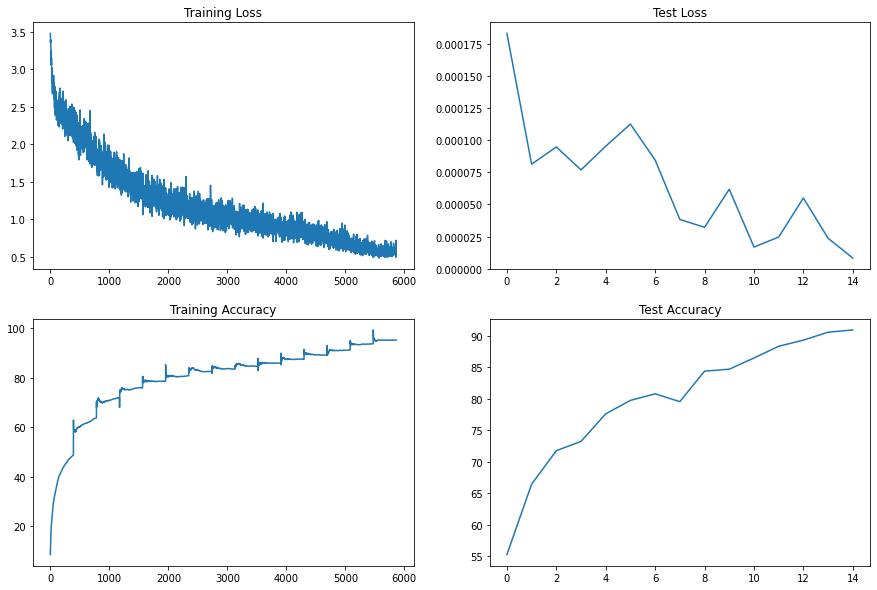

In [36]:
# Plot Train & Test Stats( i.e Loss & Accuracy)
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(model1.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(model1.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(model1.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(model1.test_acc)
axs[1, 1].set_title("Test Accuracy")


Misclassifed Images from Model
******************************


<Figure size 936x936 with 0 Axes>

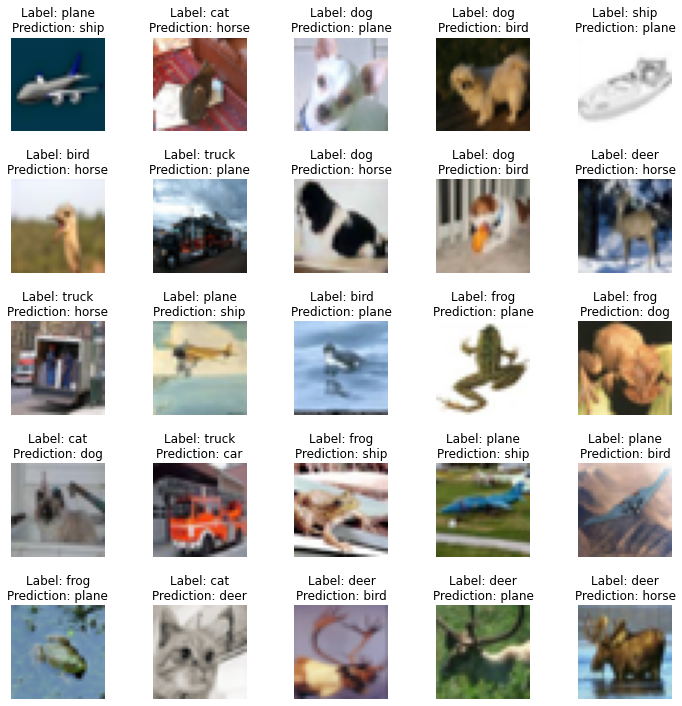

In [37]:
print('Misclassifed Images from Model')
print('*'*30)

from google.colab import files

def misclassifiedOnes(model,testloader, data,filename):
  model = model.to(device)
  dataiter = iter(testloader) 
  count = 0
  
  # Initialize plot
  fig = plt.figure(figsize=(13,13))
  row_count = -1
  fig, axs = plt.subplots(5, 5, figsize=(10, 10))
  fig.tight_layout()

  for idx, result in enumerate(data):
    # If 25 samples have been stored, break out of loop
    if idx > 24:
      break
        
    rgb_image = np.transpose(result['image'], (1, 2, 0)) / 2 + 0.5
    label = result['label'].item()
    prediction = result['prediction'].item()

    # Plot image
    if idx % 5 == 0:
      row_count += 1
    axs[row_count][idx % 5].axis('off')
    axs[row_count][idx % 5].set_title(f'Label: {classes[label]}\nPrediction: {classes[prediction]}')
    axs[row_count][idx % 5].imshow(rgb_image)
    
  # save the plot
  plt.savefig(filename)
  files.download(filename)

model.load_state_dict(torch.load("model.pt")) 
misclassifiedOnes(model,testloader, incorrect_samples,'CIFAR10.png')
